In [1]:
from sklearn.ensemble import GradientBoostingRegressor
from catboost import Pool, to_classifier, to_regressor, CatBoost
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_validate
from sklearn import linear_model
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
#from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Data from preprocessing notebook
[Preprocessing_model_1.ipynb](./Preprocessing_model_1.ipynb)

In [2]:
data = pd.read_csv("../../../Data/Dataset_splited_v1.csv",sep=",")

In [3]:
data.shape

(7846, 23)

### Sampling

In [4]:
def split_data(data,target,col="split",features_to_keep=None):
    if features_to_keep is not None :
        features_to_keep = features_to_keep
        data = data[features_to_keep]
        
    unique = data[col].unique()
    for i, v in enumerate(unique):
        if v == 0 :
            data_train = data[data[col]==v]
            y_train = data_train[target]
            X_train = data_train.drop([target,col],axis=1)
            print("train shape :",X_train.shape)
        elif v == 1 :
            data_val = data[data[col]==v]
            y_val = data_val[target]
            X_val = data_val.drop([target,col],axis=1)
            print("val shape :",X_val.shape)
        elif v == 2 :
            data_test = data[data[col]==v]
            y_test = data_test[target]
            X_test = data_test.drop([target,col],axis=1)
            print("test shape :",X_test.shape)
    
            
    return X_train, np.log(y_train), X_val, np.log(y_val), X_test, np.log(y_test)

In [5]:
data.columns

Index(['bathrooms', 'bedrooms', 'erf_size', 'floor_size', 'garages',
       'listing_date', 'pet_friendly', 'price', 'town', 'type_of_property',
       'garden', 'pool', 'secure_parking', 'parking', 'no_pets_allowed',
       'furnished', 'flatlet', 'fibre_internet', 'furnished_(optional)',
       'adsl_internet', 'satellite_internet', 'fixed_wimax_internet', 'split'],
      dtype='object')

In [6]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(data,"price")

train shape : (5492, 21)
val shape : (1177, 21)
test shape : (1177, 21)


# Model : RidgeCV (interpretable)
https://scikit-learn.org/

In [7]:
reg = linear_model.RidgeCV(alphas=np.logspace(-6, 6, 13))
reg.fit(X_train, y_train)

RidgeCV(alphas=array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
       1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06]))

## 1)  RMSE on validation set with DEFAULT PARAMETER

In [8]:
rmse = np.sqrt(mean_squared_error(y_val, reg.predict(X_val)))
print("The Root mean squared error (RMSE) on val set: {:.4f}".format(rmse))
rmse = np.sqrt(mean_squared_error(y_train, reg.predict(X_train)))
print("The Root mean squared error (RMSE) on train set: {:.4f}".format(rmse))

The Root mean squared error (RMSE) on val set: 0.3988
The Root mean squared error (RMSE) on train set: 0.4027


### Interpretation
https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html#sphx-glr-auto-examples-inspection-plot-linear-model-coefficient-interpretation-py

In [9]:
coefs = pd.DataFrame(
    reg.coef_,
    columns=['Coefficients'], index=X_train.columns
)

coefs

,Coefficients
bathrooms,0.510385
bedrooms,0.211364
erf_size,0.012779
floor_size,0.115056
garages,0.061969
listing_date,-0.078311
pet_friendly,0.020527
town,0.008838
type_of_property,0.021916
garden,-0.079692


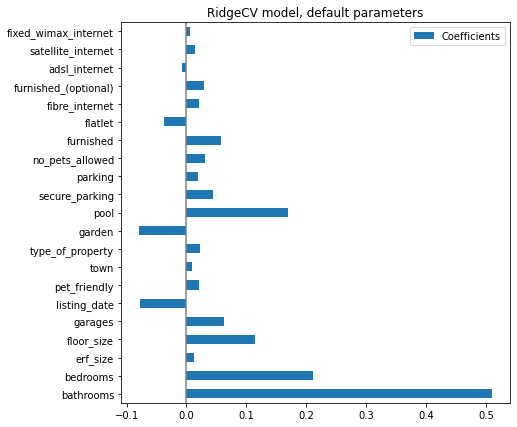

In [10]:
coefs.plot(kind='barh', figsize=(9, 7))
plt.title('RidgeCV model, default parameters')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

- bathrooms, bedrooms, pool and floor_size make price higher the most
- garden, flatlet and listing date make price lower

### Cross validation

In [11]:
X_train_val = X_val.append(X_train)
y_train_val = y_val.append(y_train)

In [12]:
reg_cv = cross_validate(reg, X_train_val, y_train_val, scoring='neg_root_mean_squared_error',cv=10, return_train_score=True, return_estimator=True)

In [13]:
print("mean RMSE :",np.abs(np.mean(reg_cv['test_score'])))
print("std RMSE :",np.abs(np.std(reg_cv['test_score'])))
print("min RMSE :",np.abs(np.max(reg_cv['test_score'])))
print("max RMSE :",np.abs(np.min(reg_cv['test_score'])))

mean RMSE : 0.4027889801239083
std RMSE : 0.016974357279444196
min RMSE : 0.37356542863458786
max RMSE : 0.4337770680452457


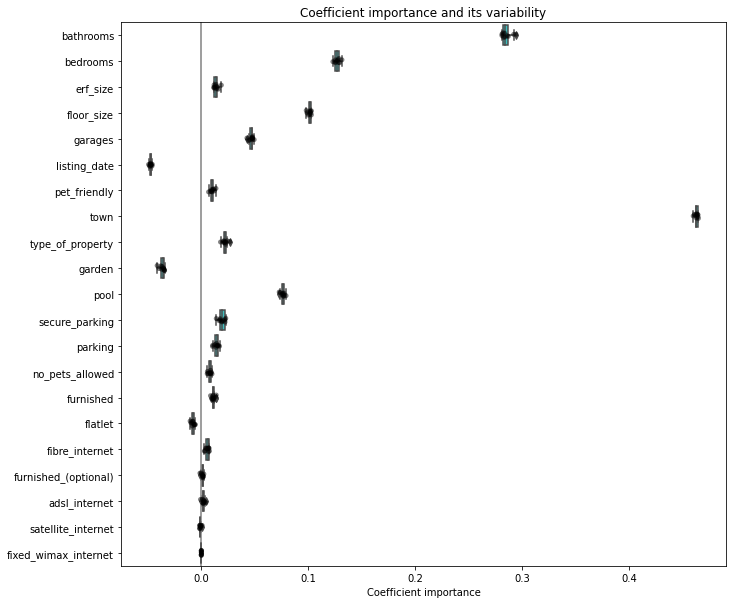

In [14]:
coefs = pd.DataFrame(
    [est.coef_ *
     X_train.std(axis=0)
     for est in reg_cv['estimator']],
    columns=X_train.columns
)
plt.figure(figsize=(14, 10))
sns.stripplot(data=coefs, orient='h', color='k', alpha=0.5)
sns.boxplot(data=coefs, orient='h', color='cyan', saturation=0.5)
plt.axvline(x=0, color='.5')
plt.xlabel('Coefficient importance')
plt.title('Coefficient importance and its variability')
plt.subplots_adjust(left=.3)

The plot of coefficient importance and its variability shows that :
- town, bathrooms, bedrooms, floor size and pool make the more impact
- bathrooms and secure parking are the most variable coefficient through cross validation

## 2) hyperparameter tuning
https://scikit-learn.org/stable/auto_examples/model_selection/plot_successive_halving_heatmap.html#sphx-glr-auto-examples-model-selection-plot-successive-halving-heatmap-py

In [15]:
param_grid = {"gcv_mode":["auto", "svd", "eigen"],"alphas":[np.logspace(-12, 12, 26),np.logspace(-6, 6, 13),np.logspace(-3, 3, 10),np.logspace(-0.1, 0.1, 10),np.logspace(-1, 1, 10)]}

In [16]:
gsh = HalvingGridSearchCV(estimator=reg, param_grid=param_grid, factor=2,cv=10,
                          random_state=45)
gsh.fit(X_train, y_train)

HalvingGridSearchCV(cv=10,
                    estimator=RidgeCV(alphas=array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
       1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06])),
                    factor=2,
                    param_grid={'alphas': [array([1.00000000e-12, 9.12010839e-12, 8.31763771e-11, 7.58577575e-10,
       6.91830971e-09, 6.30957344e-08, 5.75439937e-07, 5.24807460e-06,
       4.78630092e-05, 4.36515832e-04, 3.98107171...
       2.15443469e+02, 1.00000000e+03]),
                                           array([0.79432823, 0.83603069, 0.87992254, 0.92611873, 0.97474023,
       1.02591437, 1.07977516, 1.13646367, 1.19612833, 1.25892541]),
                                           array([ 0.1       ,  0.16681005,  0.27825594,  0.46415888,  0.77426368,
        1.29154967,  2.15443469,  3.59381366,  5.9948425 , 10.        ])],
                                'gcv_mode': ['auto', 'svd', 'eigen']},
                    random_state=45,
                    r

In [18]:
gsh.best_params_

{'alphas': array([ 0.1       ,  0.16681005,  0.27825594,  0.46415888,  0.77426368,
         1.29154967,  2.15443469,  3.59381366,  5.9948425 , 10.        ]),
 'gcv_mode': 'auto'}

In [19]:
reg = linear_model.RidgeCV(alphas= [ 0.1       ,  0.16681005,  0.27825594,  0.46415888,  0.77426368,
         1.29154967,  2.15443469,  3.59381366,  5.9948425 , 10.        ],gcv_mode= 'auto')
reg.fit(X_train, y_train)

RidgeCV(alphas=array([ 0.1       ,  0.16681005,  0.27825594,  0.46415888,  0.77426368,
        1.29154967,  2.15443469,  3.59381366,  5.9948425 , 10.        ]),
        gcv_mode='auto')

###  RMSE on validation set with tuned parameters

In [20]:
rmse = np.sqrt(mean_squared_error(y_val, reg.predict(X_val)))
print("The Root mean squared error (RMSE) on val set: {:.4f}".format(rmse))
rmse = np.sqrt(mean_squared_error(y_train, reg.predict(X_train)))
print("The Root mean squared error (RMSE) on train set: {:.4f}".format(rmse))

The Root mean squared error (RMSE) on val set: 0.3988
The Root mean squared error (RMSE) on train set: 0.4027


The tuning parameter on alphas doesn't affect the performance

### Interpretation
https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html#sphx-glr-auto-examples-inspection-plot-linear-model-coefficient-interpretation-py

In [21]:
coefs = pd.DataFrame(
    reg.coef_,
    columns=['Coefficients'], index=X_train.columns
)

coefs

,Coefficients
bathrooms,0.510385
bedrooms,0.211364
erf_size,0.012779
floor_size,0.115056
garages,0.061969
listing_date,-0.078311
pet_friendly,0.020527
town,0.008838
type_of_property,0.021916
garden,-0.079692


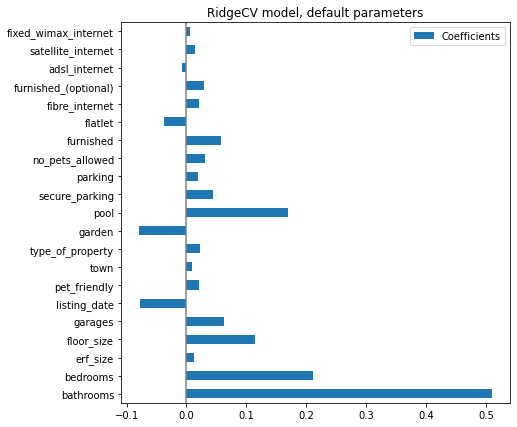

In [22]:
coefs.plot(kind='barh', figsize=(9, 7))
plt.title('RidgeCV model, default parameters')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

### Cross validation

In [23]:
X_train_val = X_val.append(X_train)
y_train_val = y_val.append(y_train)

In [24]:
reg_cv = cross_validate(reg, X_train_val, y_train_val, scoring='neg_root_mean_squared_error',cv=10, return_train_score=True, return_estimator=True)

In [25]:
print("mean RMSE :",np.abs(np.mean(reg_cv['test_score'])))
print("std RMSE :",np.abs(np.std(reg_cv['test_score'])))
print("min RMSE :",np.abs(np.max(reg_cv['test_score'])))
print("max RMSE :",np.abs(np.min(reg_cv['test_score'])))

mean RMSE : 0.4027889801239083
std RMSE : 0.016974357279444196
min RMSE : 0.37356542863458786
max RMSE : 0.4337770680452457


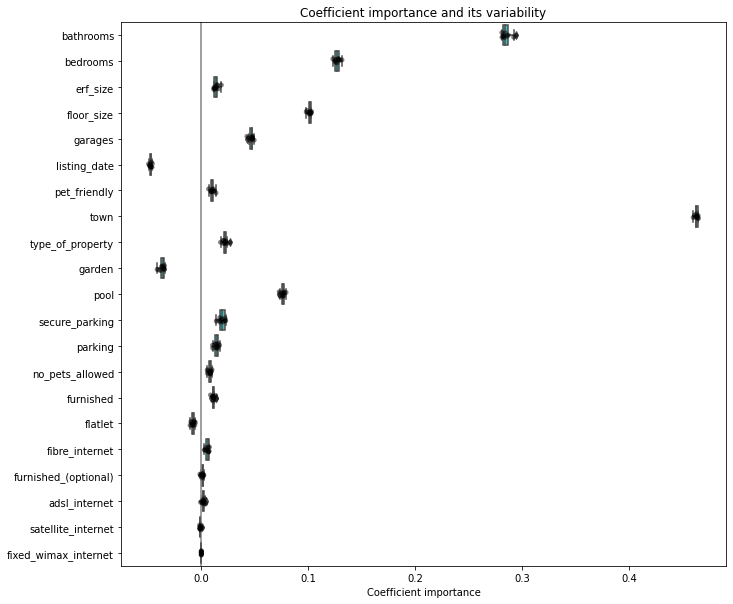

In [26]:
coefs = pd.DataFrame(
    [est.coef_ *
     X_train.std(axis=0)
     for est in reg_cv['estimator']],
    columns=X_train.columns
)
plt.figure(figsize=(14, 10))
sns.stripplot(data=coefs, orient='h', color='k', alpha=0.5)
sns.boxplot(data=coefs, orient='h', color='cyan', saturation=0.5)
plt.axvline(x=0, color='.5')
plt.xlabel('Coefficient importance')
plt.title('Coefficient importance and its variability')
plt.subplots_adjust(left=.3)

## 3) Comparison

In [27]:
print("\nModel : Cat Boost")

model = CatBoost(params={'loss_function': 'RMSE'})
print("Source model type: ", type(model))
converted_model = to_regressor(model)
converted_model.fit(X_train, y_train,verbose=False)

rmse = np.sqrt(mean_squared_error(y_val, converted_model.predict(X_val)))
print("The Root mean squared error (RMSE) on val set: {:.4f}".format(rmse))
rmse = np.sqrt(mean_squared_error(y_train, converted_model.predict(X_train)))
print("The Root mean squared error (RMSE) on train set: {:.4f}".format(rmse))

print("\nModel : Gradient Boosting")
params = {'n_estimators': 1000,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.05,
          'loss': 'ls'}

gb = GradientBoostingRegressor(**params)
gb.fit(X_train, y_train)

rmse = np.sqrt(mean_squared_error(y_val, gb.predict(X_val)))
print("The Root mean squared error (RMSE) on val set: {:.4f}".format(rmse))
rmse = np.sqrt(mean_squared_error(y_train, gb.predict(X_train)))
print("The Root mean squared error (RMSE) on train set: {:.4f}".format(rmse))

print("\nModel : Random Forest")

RF = RandomForestRegressor()
RF.fit(X_train, y_train)

rmse = np.sqrt(mean_squared_error(y_val, RF.predict(X_val)))
print("The Root mean squared error (RMSE) on val set: {:.4f}".format(rmse))
rmse = np.sqrt(mean_squared_error(y_train, RF.predict(X_train)))
print("The Root mean squared error (RMSE) on train set: {:.4f}".format(rmse))

print("\nModel : Lasso")

lasso = linear_model.Lasso()
lasso.fit(X_train, y_train)

rmse = np.sqrt(mean_squared_error(y_val, lasso.predict(X_val)))
print("The Root mean squared error (RMSE) on val set: {:.4f}".format(rmse))
rmse = np.sqrt(mean_squared_error(y_train, lasso.predict(X_train)))
print("The Root mean squared error (RMSE) on train set: {:.4f}".format(rmse))

print("\nModel : SVR")

regr = SVR(C=1.0,epsilon=0.2)
regr.fit(X_train, y_train)

rmse = np.sqrt(mean_squared_error(y_val, regr.predict(X_val)))
print("The Root mean squared error (RMSE) on val set: {:.4f}".format(rmse))
rmse = np.sqrt(mean_squared_error(y_train, regr.predict(X_train)))
print("The Root mean squared error (RMSE) on train set: {:.4f}".format(rmse))


Model : Cat Boost
Source model type:  <class 'catboost.core.CatBoost'>
The Root mean squared error (RMSE) on val set: 0.2961
The Root mean squared error (RMSE) on train set: 0.2232

Model : Gradient Boosting
The Root mean squared error (RMSE) on val set: 0.2937
The Root mean squared error (RMSE) on train set: 0.1991

Model : Random Forest
The Root mean squared error (RMSE) on val set: 0.3017
The Root mean squared error (RMSE) on train set: 0.1161

Model : Lasso
The Root mean squared error (RMSE) on val set: 0.6283
The Root mean squared error (RMSE) on train set: 0.6312

Model : SVR
The Root mean squared error (RMSE) on val set: 0.6286
The Root mean squared error (RMSE) on train set: 0.6355


## 4) Evaluate on Test

In [28]:
# FINAL MODEL with the best params from gridsearch
reg.fit(X_train_val, y_train_val)

RidgeCV(alphas=array([ 0.1       ,  0.16681005,  0.27825594,  0.46415888,  0.77426368,
        1.29154967,  2.15443469,  3.59381366,  5.9948425 , 10.        ]),
        gcv_mode='auto')

### RMSE on TEST

In [29]:
rmse = np.sqrt(mean_squared_error(y_test, reg.predict(X_test)))
print("The Root mean squared error (RMSE) on TEST set: {:.4f}".format(rmse))
rmse = np.sqrt(mean_squared_error(y_train_val, reg.predict(X_train_val)))
print("The Root mean squared error (RMSE) on train set: {:.4f}".format(rmse))

The Root mean squared error (RMSE) on TEST set: 0.4016
The Root mean squared error (RMSE) on train set: 0.4019


#### Conclusion :
- The final result on test set is not far from the cross val RMSE (0.40 and 0.39)
- the final RMSE on test set = 0.40 and on train set = 0.40 show that there isn't overfit risk

### Export model

In [30]:
import pickle

# save the model to disk
filename = 'RidgeCV_final.sav'
pickle.dump(reg, open(filename, 'wb'))